# E.x 7.3

## Description

Set step size $\lambda_i=\frac{s}{\sqrt{k}}$.

The optimal objective value is -36.16.

- Round 1: guess $s=1$. The best lower bound we get in the 100th iteration is -78. 

- Round 2: guess $s=2$. The best lower bound we get in the 100th iteration is -46. 

- Round 3: guess $s=5$. The best lower bound we get in the 100th iteration is -38, which is very close to the optimal value.

- Round 4: guess $s=10$. The best lower bound we get in the 100th iteration is -36.16, which is almost euqal to the optimal value.

- Round 5: choose a rather wild constant, i.e., guess $s=100$. The LP can converge within 10 steps.


## Conclusion
If choose step size as $\frac{s}{\sqrt{k}}$, the bigger constant $s$ is, the faster the LP converges.


In [1]:
%reset -f
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [2]:
MAXIT = 100
HarmonicStepSize = True       # If you choose False, then you have to guess a 'target value'
GUESS = -5.6                   #   but don't guess a target value higher than z!!!!
SmartInitialization = True     # Set 'False' to initialize with y=0.

# generate a random example
n = 100   # number of variables
m1 = 2000  # number of equations to relax
m2 = 500  # number of equations to keep
np.random.seed(25)   # change the seed for a differemt example 
E=0.01*np.random.randint(-5,high=5,size=(m1,n)).astype(float) #np.random.randn(m1,nt)
A=0.01*np.random.randint(-2,high=3,size=(m2,n)).astype(float) #np.random.randn(m2,nt)

# choose the right-hand sides so that Q will be feasible
xfeas=0.1*np.random.randint(0,high=5,size=n).astype(float)
h=E.dot(xfeas) - 0.1*np.random.randint(0,high=10,size=m1).astype(float)      
b=A.dot(xfeas)

# choose the objective function so that the dual of Q will be feasible
yfeas=0.1*np.random.randint(0,high=5,size=m1).astype(float)
pifeas=0.1*np.random.randint(-5,high=5,size=m2).astype(float)
c=np.transpose(E)@yfeas + np.transpose(A)@pifeas +  0.1*np.random.randint(0,high=1,size=n).astype(float)   

In [3]:
# solve the problem as one big LP --- for comparison purposes
modelQ = gp.Model()
modelQ.reset()
x = modelQ.addMVar(n)  
objective = modelQ.setObjective(c@x, GRB.MINIMIZE)
constraintsQ1 = modelQ.addConstr(E@x >= h)
constraintsQ2 = modelQ.addConstr(A@x == b)
modelQ.optimize()
if modelQ.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", modelQ.status)
    print("***** This is a problem. Model Q does not have an optimal solution")
    raise StopExecution

Academic license - for non-commercial use only - expires 2022-09-03
Using license file /Users/changli/gurobi.lic
Discarded solution information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2500 rows, 100 columns and 220069 nonzeros
Model fingerprint: 0x5aec23d5
Coefficient statistics:
  Matrix range     [1e-02, 5e-02]
  Objective range  [1e+00, 3e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-19, 1e+00]
Presolve time: 0.04s
Presolved: 2500 rows, 100 columns, 220069 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.9112000e+32   1.786304e+34   3.911200e+02      0s
     151   -3.6159700e+01   0.000000e+00   0.000000e+00      0s

Solved in 151 iterations and 0.11 seconds
Optimal objective -3.615970000e+01


In [4]:
# 'SmartInitialization' chooses the initial y so that the dual of the Lagrangian Subproblem has (pi=0 as) 
# a feasible solution, thus making sure that the initial Lagrangian Subproblem is not unbounded.
if SmartInitialization:
    modelY = gp.Model()
    modelY.reset()
    yvar = modelY.addMVar(m1)  
    constraintsY = modelY.addConstr(np.transpose(E)@yvar <= c)
    modelY.optimize()
    y=yvar.X
else: y=np.zeros(m1)

# initialization 
k=1
bestlb = -np.Inf

# set up the Lagrangian relaxation
modelL = gp.Model()
modelL.reset()
modelL.setParam('OutputFlag', 0)   # quiet the Gurobi output 
x = modelL.addMVar(n)  
constraintsL = modelL.addConstr(A@x == b)
objective = modelL.setObjective((c-y.dot(E))@x, GRB.MINIMIZE)

modelL.optimize()
if modelL.status != GRB.Status.OPTIMAL:
    print("***** Gurobi solve status:", modelL.status)
    print("***** This is a problem. Lagrangian Subproblem is unbounded.")
    print("***** The algorithm cannot work with this starting y.")
    raise StopExecution
v = y.dot(h) + modelL.Objval
results1=[0]
results2=[v]
bestlb = v

Discarded solution information
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 100 rows, 2000 columns and 180044 nonzeros
Model fingerprint: 0xff139c72
Coefficient statistics:
  Matrix range     [1e-02, 5e-02]
  Objective range  [0e+00, 0e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve time: 0.04s
Presolved: 100 rows, 2000 columns, 180044 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 4.950e+03
 Factor NZ  : 5.050e+03 (roughly 1 MByte of memory)
 Factor Ops : 3.384e+05 (less than 1 second per iteration)
 Threads    : 6

Barrier performed 0 iterations in 0.08 seconds
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Solved in 57 iterations and 0.09 seconds
Optimal objective  0.000000000e+00
Disca

In [5]:
while k < MAXIT:
    k += 1
    g = h - E.dot(x.X)
    if HarmonicStepSize:
        stepsize = 10/(k**.5)            # This one converges in theory, but it is slow.
    else:                          # Instead, you can make a GUESS at the max
        stepsize = (GUESS - v)/(g@g)   # and then use this 'Polyak' stepsize
    y = np.maximum(y + stepsize*g, np.zeros(m1))   # The projection keeps y>=0. 
    objective = modelL.setObjective((c-y.dot(E))@x, GRB.MINIMIZE)
    modelL.optimize()
    if modelL.status != GRB.Status.OPTIMAL:
        k -= 1
        print("***** Gurobi solve status:", GRB.OPTIMAL)
        print("***** This is a problem. Lagrangian Subproblem is unbounded.")
        print("***** The algorithm cannot continue after k =",k)
        break
    v = y.dot(h) + modelL.Objval
    bestlb = np.max((bestlb,v))
    results1=np.append(results1,k-1)
    results2=np.append(results2,v)
 
print("***** z:", modelQ.Objval)
print("***** first lower bound:", results2[0])
print("***** best lower bound:", bestlb)

***** z: -36.15970000000003
***** first lower bound: -183.2378071287958
***** best lower bound: -36.60343929910567


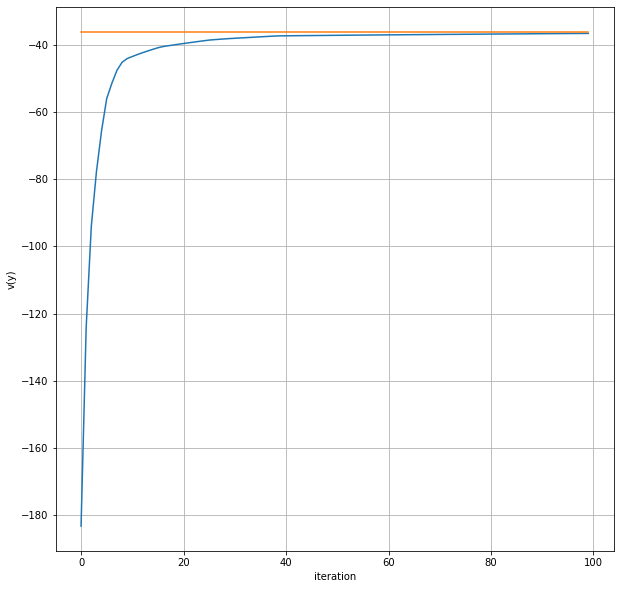

In [6]:
if k > 1:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot(results1, results2)
    ax.plot(results1, modelQ.Objval*np.ones(k))
    ax.set(xlabel='iteration', ylabel='v(y)')
    ax.grid()
    plt.show()